Integration failed with status -1: Required step size is less than spacing between numbers.
Final time: 99.99000000000001
Quaternion constraint violated at time steps: [0.000e+00 1.000e-02 2.000e-02 ... 9.997e+01 9.998e+01 9.999e+01]


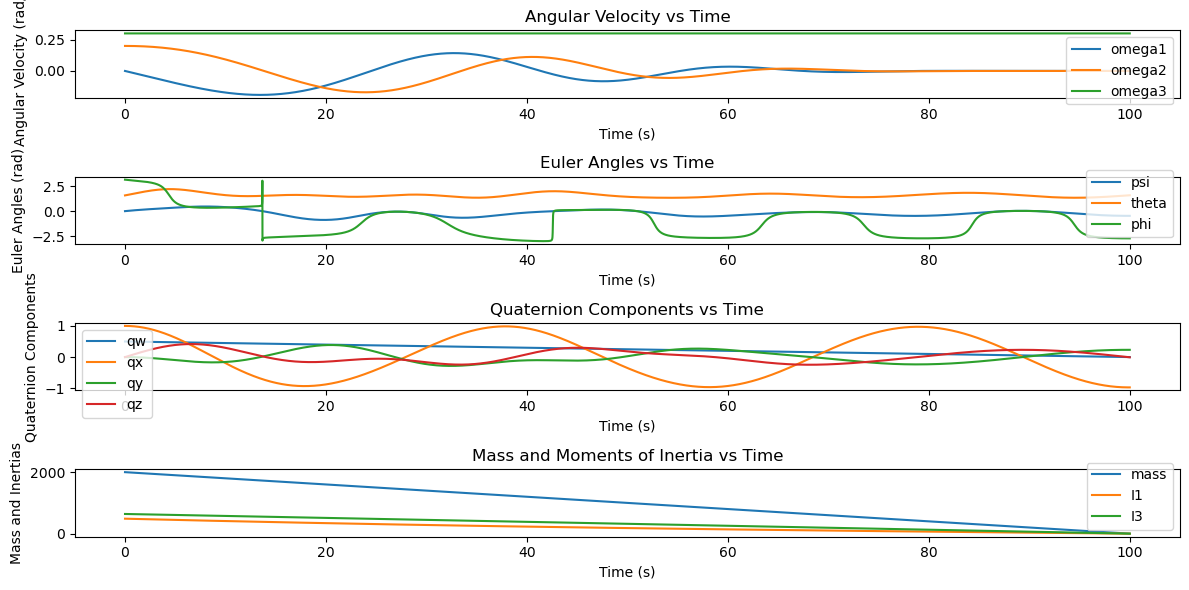

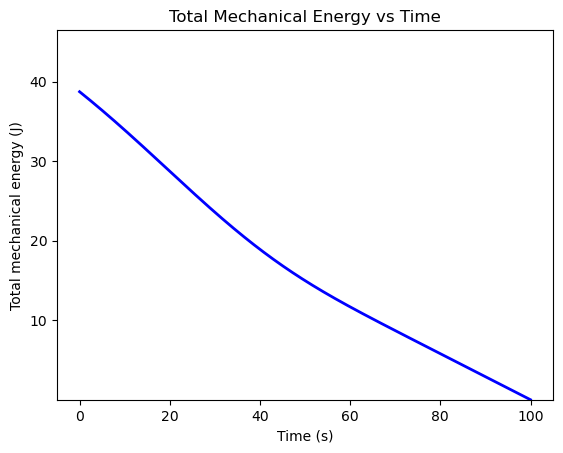

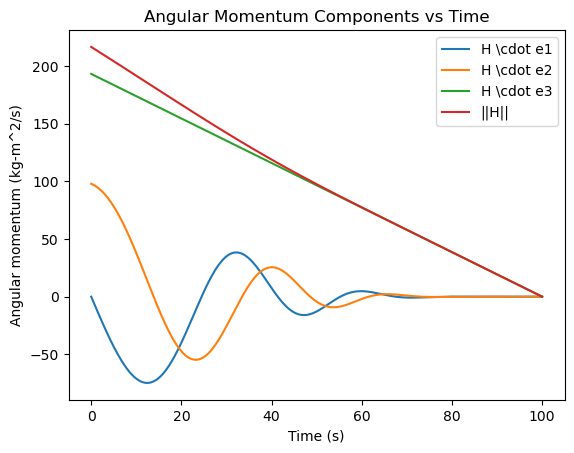

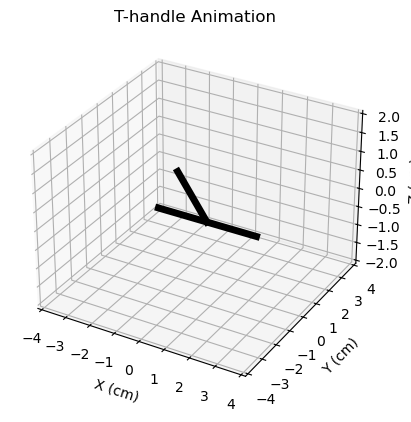

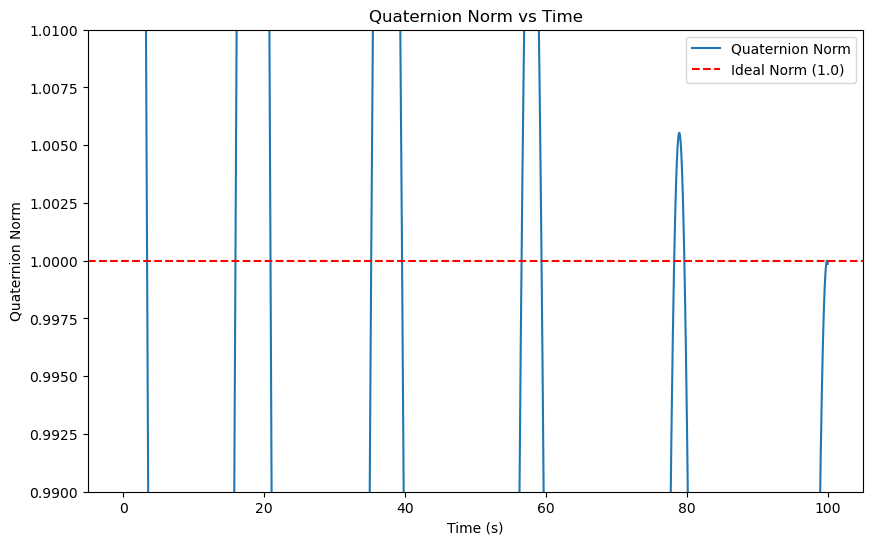

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Define the global physical parameters for the variable mass system
rho_ini = 1000
L = 1  # m
h = L / 2
z0 = h
R = 0.8 * L  # m
w0 = 0.2

# Initial angular rates
w10 = 0
w20 = w0
w30 = 0.3

# Initial mass properties
mf0 = np.pi * R**2 * L * rho_ini  # kg
I10 = mf0 * (R**2 / 4 + h**2 / 3)  # kg*m^2
I30 = mf0 * R**2 / 2  # kg*m^2
Theta0 = 0
F0 = 0
tb = 100  # s
m_dot = -mf0 / tb
z_dot = m_dot / (2 * rho_ini * np.pi * R**2)

# Quaternion initial conditions (representing no initial rotation)
q0 = [1, 0, 0, 0]  # (w, x, y, z)

# Combine initial conditions
Y0 = [mf0, I10, I30, w10, w20, w30, Theta0, F0, z0] + q0

# Define the differential equations (endburn)
def endburn(t, w):
    m, I1, I3, w1, w2, w3, Theta, F, z, qw, qx, qy, qz = w

    # Mass varying terms
    md = m_dot
    I1d = md * (R**2 / 4 + z**2)
    I3d = md * R**2 / 2

    # Distance of mass center from exit plane
    ze = 2 * h - z

    # Equations of motion for the axisymmetric cylinder undergoing uniform burn
    w1d = (I1 - I3) * w2 * w3 / I1 - (I1d - md * (ze**2 + R**2 / 4)) * w1 / I1
    w2d = -(I1 - I3) * w1 * w3 / I1 - (I1d - md * (ze**2 + R**2 / 4)) * w2 / I1
    w3d = -(I3d - md * R**2 / 2) * w3 / I3
    Thetad = (1 - I3 / I1) * w3
    Fd = -(I1d - md * (ze**2 + R**2 / 4)) / I1
    zd = md / m * z

    # Quaternion derivative
    omega_quat = np.array([0, w1, w2, w3])
    quat = np.array([qw, qx, qy, qz])
    quat_dot = 0.5 * np.array(quat_mult(quat, omega_quat))

    wd = [md, I1d, I3d, w1d, w2d, w3d, Thetad, Fd, zd] + quat_dot.tolist()

    # other variables
    Gam = np.exp(F)
    ext = np.zeros(9)
    ext[0] = w0 * Gam * np.cos(Theta)
    ext[1] = -w0 * Gam * np.sin(Theta)
    ext[2] = I1
    ext[3] = I3
    ext[6] = ze
    ext[7] = np.sqrt(I1 / m)  # transverse radius of gyration
    ext[8] = np.sqrt(I3 / m)  # spin radius of gyration

    # nutation angle calculations
    H12 = I1 * w0 * Gam
    H3 = I3 * w3
    ext[4] = np.arctan(H12 / H3)
    ext[5] = np.arctan(w0 * Gam / w3)

    return wd, ext

# Function to multiply two quaternions
def quat_mult(q, r):
    """
    Multiply two quaternions q and r.
    """
    w1, x1, y1, z1 = q
    w2, x2, y2, z2 = r
    return [
        w1*w2 - x1*x2 - y1*y2 - z1*z2,
        w1*x2 + x1*w2 + y1*z2 - z1*y2,
        w1*y2 - x1*z2 + y1*w2 + z1*x2,
        w1*z2 + x1*y2 - y1*x2 + z1*w2
    ]

# Time span for the simulation
dt = 0.01
t_eval = np.arange(0, tb, dt)

# Solve the ODEs
sol = solve_ivp(lambda t, y: endburn(t, y)[0], [0, tb], Y0, t_eval=t_eval, atol=1e-9, rtol=1e-8)

# Check if the integration was successful
if sol.status == 0:
    print("Integration successful.")
else:
    print(f"Integration failed with status {sol.status}: {sol.message}")

# Print the final time to check if it reached the end of the burn time
print(f"Final time: {sol.t[-1]}")

# Extract results
t = sol.t
m = sol.y[0]
I1 = sol.y[1]
I3 = sol.y[2]
omega1 = sol.y[3]
omega2 = sol.y[4]
omega3 = sol.y[5]
chi = sol.y[6]
F = sol.y[7]
qw, qx, qy, qz = sol.y[8], sol.y[9], sol.y[10], sol.y[11]

# Compute the quaternion norm and check for violations
quat_norm = np.sqrt(qw**2 + qx**2 + qy**2 + qz**2)
norm_violation_indices = np.where(np.abs(quat_norm - 1) > 1e-6)[0]

if len(norm_violation_indices) > 0:
    print(f"Quaternion constraint violated at time steps: {t[norm_violation_indices]}")
else:
    print("Quaternion constraint satisfied throughout the simulation.")

# Use endburn to compute additional variables (ext) over time
ext = np.zeros((len(t), 9))
for i in range(len(t)):
    _, ext[i, :] = endburn(t[i], sol.y[:, i])

# Function to convert quaternion to Euler angles (Z-X-Z sequence)
def quat_to_euler_zxz(q):
    """
    Convert a quaternion to Euler angles (Z-X-Z sequence).
    """
    w, x, y, z = q
    # Compute the Euler angles
    psi = np.arctan2(2*(w*z + x*y), 1 - 2*(y**2 + z**2))
    theta = np.arccos(2*(w*y - z*x))
    phi = np.arctan2(2*(w*z + y*x), 1 - 2*(x**2 + y**2))
    return psi, theta, phi

# Extract Euler angles from quaternions
psi, theta, phi = np.zeros(len(qw)), np.zeros(len(qw)), np.zeros(len(qw))
for i in range(len(qw)):
    psi[i], theta[i], phi[i] = quat_to_euler_zxz([qw[i], qx[i], qy[i], qz[i]])

# Plot the results
plt.figure(figsize=(12, 6))

# Plot angular velocities
plt.subplot(4, 1, 1)
plt.plot(sol.t, omega1, label='omega1')
plt.plot(sol.t, omega2, label='omega2')
plt.plot(sol.t, omega3, label='omega3')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.title('Angular Velocity vs Time')
plt.legend()

# Plot Euler angles
plt.subplot(4, 1, 2)
plt.plot(sol.t, psi, label='psi')
plt.plot(sol.t, theta, label='theta')
plt.plot(sol.t, phi, label='phi')
plt.xlabel('Time (s)')
plt.ylabel('Euler Angles (rad)')
plt.title('Euler Angles vs Time')
plt.legend()

# Plot quaternions
plt.subplot(4, 1, 3)
plt.plot(sol.t, qw, label='qw')
plt.plot(sol.t, qx, label='qx')
plt.plot(sol.t, qy, label='qy')
plt.plot(sol.t, qz, label='qz')
plt.xlabel('Time (s)')
plt.ylabel('Quaternion Components')
plt.title('Quaternion Components vs Time')
plt.legend()

# Plot mass and moments of inertia
plt.subplot(4, 1, 4)
plt.plot(sol.t, m, label='mass')
plt.plot(sol.t, I1, label='I1')
plt.plot(sol.t, I3, label='I3')
plt.xlabel('Time (s)')
plt.ylabel('Mass and Inertias')
plt.title('Mass and Moments of Inertia vs Time')
plt.legend()

plt.tight_layout()
plt.show()

# Plot the T-handle's total mechanical energy over time
E = 0.5 * (I1 * omega1**2 + I1 * omega2**2 + I3 * omega3**2)

plt.figure()
plt.plot(sol.t, E, '-b', linewidth=2)
plt.xlabel('Time (s)')
plt.ylabel('Total mechanical energy (J)')
plt.ylim([min(E) * 0.8, max(E) * 1.2])  # Set fixed y-axis limits
plt.title('Total Mechanical Energy vs Time')
plt.show()

# Plot the components of the angular momentum about the mass center and the total angular momentum over time
H1 = I1 * omega1  # kg-m^2/s
H2 = I1 * omega2  # kg-m^2/s
H3 = I3 * omega3  # kg-m^2/s
H = np.sqrt(H1**2 + H2**2 + H3**2)  # kg-m^2/s

plt.figure()
plt.plot(sol.t, H1, label='H \cdot e1')
plt.plot(sol.t, H2, label='H \cdot e2')
plt.plot(sol.t, H3, label='H \cdot e3')
plt.plot(sol.t, H, label='||H||')
plt.xlabel('Time (s)')
plt.ylabel('Angular momentum (kg-m^2/s)')
plt.title('Angular Momentum Components vs Time')
plt.legend()
plt.show()

# Function to convert quaternion to rotation matrix
def quat_to_rot_matrix(q):
    """
    Convert a quaternion q to a rotation matrix.
    """
    w, x, y, z = q
    return np.array([
        [1 - 2*(y**2 + z**2), 2*(x*y - z*w), 2*(x*z + y*w)],
        [2*(x*y + z*w), 1 - 2*(x**2 + z**2), 2*(y*z - x*w)],
        [2*(x*z - y*w), 2*(y*z + x*w), 1 - 2*(x**2 + y**2)]
    ])

def animate_t_handle_quat(qw, qx, qy, qz, dt):
    # Specify dimensions for the T-handle
    LAG = 0.5  # cm
    LBC = 4  # cm
    LAD = 2  # cm

    # Initialize arrays to store the T-handle's orientation and key points
    e1 = np.zeros((3, len(qw)))
    e2 = np.zeros((3, len(qw)))
    e3 = np.zeros((3, len(qw)))
    xA, yA, zA = np.zeros(len(qw)), np.zeros(len(qw)), np.zeros(len(qw))
    xB, yB, zB = np.zeros(len(qw)), np.zeros(len(qw)), np.zeros(len(qw))
    xC, yC, zC = np.zeros(len(qw)), np.zeros(len(qw)), np.zeros(len(qw))
    xD, yD, zD = np.zeros(len(qw)), np.zeros(len(qw)), np.zeros(len(qw))

    # Calculate the orientation of the T-handle over time
    for k in range(len(qw)):
        q = [qw[k], qx[k], qy[k], qz[k]]
        R = quat_to_rot_matrix(q)
        e1[:, k] = R @ np.array([1, 0, 0])
        e2[:, k] = R @ np.array([0, 1, 0])
        e3[:, k] = R @ np.array([0, 0, 1])
        xA[k] = -LAG * e2[0, k]
        yA[k] = -LAG * e2[1, k]
        zA[k] = -LAG * e2[2, k]
        xB[k] = xA[k] + LBC / 2 * e1[0, k]
        yB[k] = yA[k] + LBC / 2 * e1[1, k]
        zB[k] = zA[k] + LBC / 2 * e1[2, k]
        xC[k] = xA[k] - LBC / 2 * e1[0, k]
        yC[k] = yA[k] - LBC / 2 * e1[1, k]
        zC[k] = zA[k] - LBC / 2 * e1[2, k]
        xD[k] = xA[k] + LAD * e2[0, k]
        yD[k] = yA[k] + LAD * e2[1, k]
        zD[k] = zA[k] + LAD * e2[2, k]

    # Set up the figure window
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X (cm)')
    ax.set_ylabel('Y (cm)')
    ax.set_zlabel('Z (cm)')
    ax.set_xlim([-LBC, LBC])
    ax.set_ylim([-LBC, LBC])
    ax.set_zlim([-LAD, LAD])
    ax.set_title('T-handle Animation')

    # Draw the T-handle
    AD, = ax.plot([xA[0], xD[0]], [yA[0], yD[0]], [zA[0], zD[0]], 'k-', linewidth=5)
    BC, = ax.plot([xB[0], xC[0]], [yB[0], yC[0]], [zB[0], zC[0]], 'k-', linewidth=5)

    # Animate the T-handle's motion by updating the figure with its current orientation
    def update(k):
        AD.set_data([xA[k], xD[k]], [yA[k], yD[k]])
        AD.set_3d_properties([zA[k], zD[k]])
        BC.set_data([xB[k], xC[k]], [yB[k], yC[k]])
        BC.set_3d_properties([zB[k], zC[k]])
        return AD, BC,

    ani = FuncAnimation(fig, update, frames=len(qw), interval=dt * 1000, blit=True)
    plt.show()

# Example usage
# Assuming `qw`, `qx`, `qy`, `qz` are the quaternion components obtained from the previous solution
animate_t_handle_quat(qw, qx, qy, qz, dt)

# Plot the quaternion norm over time
plt.figure(figsize=(10, 6))
plt.plot(t, quat_norm, label='Quaternion Norm')
plt.axhline(y=1.0, color='r', linestyle='--', label='Ideal Norm (1.0)')
plt.xlabel('Time (s)')
plt.ylabel('Quaternion Norm')
plt.ylim([0.99, 1.01])  # Adjust y-limits for better visualization
plt.title('Quaternion Norm vs Time')
plt.legend()
plt.show()

